In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 

up =  "\u2191"  # ↑
down = "\u2193"  # ↑

boundary_conditions = {
     "periodic",
     "aperiodic",
     "buffered",
     "random",
}    
    
#TODO: add glass 
magnetic_character = {
    "ferromagnetic": 1, 
    "antiferromagnetic": 1,     
    "paramagnetic":0,   
    "glassy":  
}

def hamiltonian(lattice:"SpinLattice")-> (float | int ):
    interaction_energy = 0.0
    h_energy = np.sum(-lattice.spins*lattice.h)
    for i in range(1,lattice.N+1):
        for j in  range(1, lattice.N+1):
            spin = lattice.spins[i,j]
            neighbors = np.array([ lattice.spins[i-1,j], 
                                lattice.spins[i+1,j],
                                lattice.spins[i,j-1],
                                lattice.spins[i,j+1]])
            
        interaction_energy += np.sum(-lattice.J* neighbors*spin)
    
    H = -lattice.J*interaction_energy-h_energy
    return H


H = hamiltonian

def monte_carlo(lattice: "SpinLattice",iterations: (int)) -> None: 

    energies = []

    for i in range(0,iterations+1):

# np.random.choice([lattice.spins.shape,lattice.spins.shape], 2, replace=False) 

        index = np.random.choice(np.arange(1,lattice.N+1), lattice.dimension, replace=False)  
        E0 = hamiltonian(lattice)
        lattice.spins[*index] = -1.0 * lattice.spins[*index]
        E = hamiltonian(lattice)
        ΔE = E-E0 
        if ΔE < 0 : 
            pass 
        else: 
            p_keep = np.exp(-lattice.β*ΔE)
            accept_reject = np.random.choice([1.0,-1.0],p=[p_keep,1-p_keep ])
            lattice.spins[*index] = accept_reject * lattice.spins[*index]
        energies.append(E)


    return energies

# def buffer_find_neighbors(spin_row, spin_column, spin_tensor:"SpinLattice.spins", dimension:(int|float)=2): 
#    neighbors= np.zeros(dimension*dimension)
#    neighbors[0] = lattice.spins[spin_row-1,spin_column]*spin
#    neighbors[1] = lattice.spins[spin_row+1,spin_column]*spin
#    neighbors[2] = lattice.spins[spin_row,spin_column-1]*spin
#    neighbors[3] = lattice.spins[spin_row,spin_column+1]*spin
#    return neighbors

# TODO: add dimension
# TODO: add neighbor length 
class SpinLattice():
    
    def __init__(self,
                 N: (int | float),
                dimension:(int) = 2 , 
                temperature:(int| float ) = 1 , 
                 boundary_condition: str="buffered",
                 spin_number:(int | float) = 1/2, 
                 scale_number:(int | float) = 2, 
                 buffer_pad: (int | float) = 0, 
                 interaction_strength: (int| float)= 1.0,
                 magnetic_strength: (int|float)=1.0 ,
                 seed: int = None):
                
                if seed != None:
                    np.random.seed(seed)

                self.inverse_temperature = 1/temperature
                self.β = 1/temperature
                self.dimension = dimension
                self.d = dimension
                self.N = N
                final_value = spin_number+.5 if spin_number%1 !=0 else spin_number+1
                spin_values = np.arange(-spin_number,final_value)*scale_number

                self.spins = np.random.choice(spin_values,size=(self.N,self.N))
                self.h = magnetic_strength
                self.bc = boundary_condition
                self.J = interaction_strength
                self.interaction_strength = interaction_strength

                if self.bc == "buffered":
                  #https://numpy.org/doc/stable/reference/generated/numpy.pad.html
                  self.spins = np.pad(self.spins, pad_width = 1)


    def __str__(self):
         spin_string = np.where(self.spins == 1, up, np.where(self.spins == -1, down, self.spins))
         return str(spin_string[1:self.N+1,1:self.N+1])

                      

    def energy(self):
        interaction_energy = 0.0
        h_energy = np.sum(-self.lattice.spins*self.lattice.h)
        for i in range(1,self.lattice.N+1):
            for j in  range(1, self.lattice.N+1):
                spin = self.lattice.spins[i,j]
                neighbors = np.array([self.lattice.spins[i-1,j], 
                                    self.lattice.spins[i+1,j],
                                    self.lattice.spins[i,j-1],
                                    self.lattice.spins[i,j+1]])
                
            interaction_energy += np.sum(-self.lattice.J* neighbors*spin)
        
        H = -self.lattice.J*interaction_energy-h_energy
        return H
         
    
    # def display(self):
    #     # check N , if greater than N, produce a subset, first M 
    #     if 



In [29]:
lattice = SpinLattice(N=20, interaction_strength=1.0, magnetic_strength=1.0)


In [40]:
energies = monte_carlo(lattice,2000)

[['↑' '↓' '↓' '↓' '↑' '↓' '↓' '↓' '↓' '↓' '↓' '↑' '↓' '↑' '↓' '↓' '↓' '↑'
  '↑' '↓']
 ['↓' '↓' '↓' '↑' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓'
  '↓' '↑']
 ['↓' '↓' '↑' '↓' '↓' '↑' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓'
  '↓' '↓']
 ['↓' '↑' '↓' '↑' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓'
  '↓' '↑']
 ['↓' '↓' '↓' '↓' '↓' '↑' '↓' '↓' '↓' '↓' '↑' '↓' '↓' '↓' '↓' '↓' '↓' '↓'
  '↓' '↓']
 ['↓' '↓' '↓' '↑' '↓' '↑' '↓' '↓' '↓' '↑' '↓' '↓' '↑' '↓' '↑' '↓' '↓' '↓'
  '↓' '↑']
 ['↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓'
  '↓' '↓']
 ['↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓'
  '↓' '↑']
 ['↑' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↓' '↑' '↓' '↓' '↓' '↓'
  '↑' '↓']
 ['↓' '↓' '↑' '↓' '↓' '↓' '↓' '↓' '↓' '↑' '↓' '↑' '↓' '↓' '↓' '↓' '↓' '↓'
  '↓' '↑']
 ['↓' '↓' '↓' '↓' '↓' '↑' '↓' '↓' '↓' '↓' '↑' '↓' '↑' '↑' '↓' '↓' '↓' '↓'
  '↓' '↓']
 ['↓' '↓' '↑' '↓' '↑' '↓' '↓' '↓' '↓' '↓' '↓' '↑' '↓' '↓' '↓' '↑'

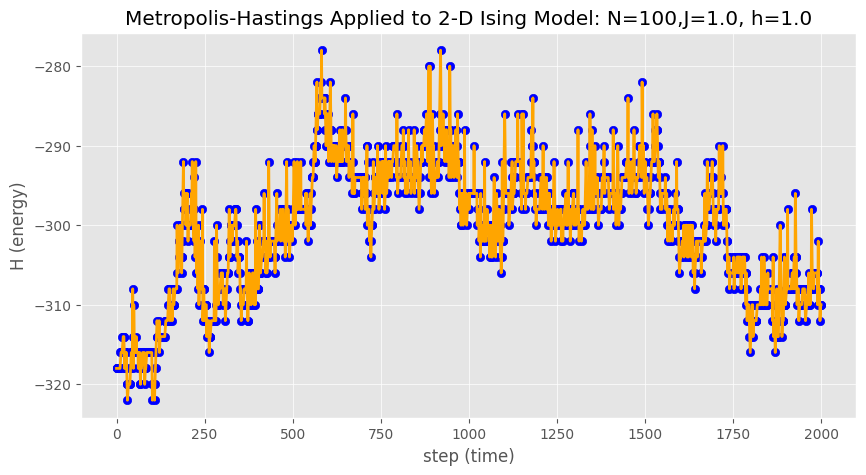

In [41]:

plt.style.use('ggplot') 

plt.figure(figsize=(10,5))
plt.scatter(np.arange(2001), energies,color="blue")
plt.plot(energies,color="orange")
# plt.grid()
plt.xlabel("step (time)")
plt.ylabel("H (energy)")
plt.title("Metropolis-Hastings Applied to 2-D Ising Model: N=100,J=1.0, h=1.0")
plt.show() 
